# Challenge. Your categories
Now it's your turn. We'll reset the Dataframe so that no categories exist, and it's up to you to create the categories based on keywords in the name and description. Feel free to go wild and make as many categories as you like.
* Remember you can also use regex to refine your searches.
* Remember you can use the or operator `|` to search for multiple terms at once.
* Remember to tidy up any untidy strings at the end.

## Load the Data

In [ ]:
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

csv_names = ['products', 'orders', 'orderlines']

# Google Drive file ids


files_id = {
    'products':"1Me1equ0TUXoVnmHU31FPj0XrXZlmRXvd"
}

# Read data from Google Drive
products_me = pd.read_csv(gd_path(files_id['products']), sep=",")

Preprocessing

In [ ]:
# Replace the DataFrame with a copy of another DataFrame
product_category_df = products_me.copy()

# Drop specific columns from the DataFrame
product_category_df = product_category_df.drop(columns=(['cl_deff',
                                                         'cl_deff_2',
                                                         'price',
                                                         'promo_price'])).copy()

# Add a new column 'brands' based on the values in the 'sku' column
product_category_df['brands'] = product_category_df.sku.str[:3].copy()
product_category_df.sample()


,sku,long,name,desc,cl_price,type,brands
8316,AP20233,Apple,Like new - Apple Mac mini Core i5 28GHz | 8GB ...,Computer Core i5 Mac mini refitted 28GHz | 8GB...,1105.59,"5,44E+11",AP2


Exploration of category `type` and `brand`

In [ ]:
product_category_df.type.value_counts(normalize=True).sample(5)

12285400     0.000584
5406         0.000195
51912158     0.000097
113464259    0.000292
5720         0.003993
Name: type, dtype: float64

In [ ]:
 most_30_count_type = (
                      product_category_df.type.value_counts(normalize=True)
                                         .nlargest(30)
                                         .reset_index()
                                         .drop('type', axis=1)
                      )

In [ ]:
most_30_count_type.sample(5)

,index
0,12175397
27,1405
28,13555403
26,13615399
21,1229


In [ ]:
(
product_category_df[['type','brands']].value_counts(normalize=True)
                                      .head(30)
                                      .reset_index()
                                      .sort_values(by=0)
                                      .sample(5)
)

,type,brands,0
3,1433,PAC,0.020843
14,1364,OWC,0.009058
22,1298,OWC,0.006721
11,2158,APP,0.010422
24,11865403,GRT,0.006526


Reducing the scope of the search to the top `type` that most often occur.


In [ ]:
top_30_types = most_30_count_type.merge(product_category_df,
                                        how="inner",
                                        left_on='index',
                                        right_on='type').copy()
top_30_types[top_30_types.name.str.contains('Watch')].sample(5)

,index,sku,long,name,desc,cl_price,type,brands
7733,2449,NOM0020-A,Nomad,Open - Nomad Vulcanized LSR Silicone Strap Str...,Reconditioned silicone strap matte black for A...,39.99,2449,NOM
7752,2449,HOC0008,Hoco Nike,Nike hoco Series Apple Watch Strap 42mm Black ...,Silicone Strap Sports Watch 42mm Apple,45.00,2449,HOC
7705,2449,CYG0072,Cygnett,Cygnett Luxband Apple Watch Strap 42mm brown,Leather strap for easy installation Apple Watc...,49.99,2449,CYG
2946,1298,SAT0019-A,Satechi,Open - Satechi Apple Watch Support Aluminum Si...,Stand with aluminum finish and slot Charging C...,34.99,1298,SAT
7718,2449,XDO0037,X-Doria,X-Doria Metal Mesh Strap Watch 38mm Black Apple,Mesh belt stainless steel X-Doria for Apple Wa...,49.99,2449,XDO


# Analysis of `desc` and `name`.

### Looking for generic terms that mostly occur in these columns

In [ ]:
def top_word_desc(df, column, count=50):
    # Replace spaces with commas in the specified column and convert it to a list
    list_of_desc = df[column].str.replace(' ', ',').to_list()

    # Join the list elements with commas
    combined_list = ','.join(list_of_desc)

    # Split the joined string by commas and create a DataFrame
    df_desc = pd.DataFrame(list(combined_list.split(',')))

    # Filter words that consist only of alphabetic characters and start with a capital letter
    filtered_words = (
                      df_desc[df_desc[0].str.isalpha() &
                              df_desc[0].str.match(r'\b[A-Z][a-zA-Z]*\b')]
                              .value_counts(normalize=True)
                              .sort_values(ascending=False).head(count)
                      )

    return filtered_words

In [ ]:
top_word_desc(top_30_types, 'desc', count=50).sample(5)

External    0.006504
HDMI        0.006365
Mid         0.006191
Hard        0.020904
GHz         0.006678
dtype: float64

In [ ]:
top_word_desc(top_30_types, 'name', count=5)

Case     0.039591
Apple    0.038044
Pro      0.033172
RAM      0.028299
SSD      0.023215
dtype: float64

In [ ]:
top_word_desc(product_category_df, 'long', count=5)

Apple     0.200691
Pack      0.152149
OWC       0.034152
Repair    0.022544
Belkin    0.021297
dtype: float64

Combining the findings into one data frame.

In [ ]:
df_all_column = (
                 top_word_desc(top_30_types, 'desc', count=100)
                 .to_frame()
                 .rename(columns={0:'test'})
                 .reset_index()
                 .drop('test',axis=1)
                 .rename(columns={0:'desc'})
)

In [ ]:
df_all_column['name'] = (
                 top_word_desc(top_30_types, 'name', count=100)
                 .to_frame()
                 .rename(columns={0:'test'})
                 .reset_index()
                 .drop('test',axis=1)
                 .rename(columns={0:'name'})
)

Only use the one-worded brands

In [ ]:
brands_df = (
             product_category_df[~product_category_df.long.str.contains(" ")]
                                                     .long.value_counts()
                                                     .to_frame()
                                                     .reset_index()
                                                     .drop('long',axis=1)
                                                     .rename(columns={'index':'brands_word'})

)

In [ ]:
brands_df.sample(5)

,brands_word
71,Maclocks
33,Adonit
120,Stacked
55,Nomad
112,QDos


In [ ]:
df_all_column_brand =(
                      df_all_column.merge(brands_df,
                                          how="left",
                                          left_on="name",
                                          right_on="brands_word")
                      .copy()
)

In [ ]:
pd.set_option('display.max_rows', None)
df_all_column_brand.sample(5)

,desc,name,brands_word
67,Xeon,HDD,NaN
2,PC,Pro,NaN
33,Cover,Monitor,NaN
83,Series,Strap,NaN
79,GB,NewerTech,NewerTech


In [ ]:
df_all_column_brand[df_all_column_brand.brands_word.isna()].desc.sort_values().sample(5)

61    Wireless
92      Screen
25         Bar
52         HDD
94      Server
Name: desc, dtype: object

In [ ]:
df_all_column_brand[df_all_column_brand.brands_word.isna()].name.sort_values().sample(5)

63    External
55    Wireless
6         Open
34      Silver
74        Rosa
Name: name, dtype: object

## Exploring category `repair`

In [ ]:
top_30_types[
            ~ (top_30_types.sku.str.contains('APP'))
            & (top_30_types.desc.str.contains('IPhone', case=False))
            & (top_30_types.cl_price > 400)
            ].sample(5)

,index,sku,long,name,desc,cl_price,type,brands,category
3696,11905404,ELG0037,Elgato,Elgato Eve Wireless Sensor Room Interior,Sensor air quality temperature and humidity fo...,799.931,11905404,ELG,NaN
3593,11905404,PAC1400,Pack,Elgato Eve and Energy Plug Power Wireless Sens...,Control on / off and power / consumer remote s...,999.799,11905404,PAC,Watch
3935,11905404,FIB0007,Fibaro,Fibaro Monoxide Detector Sensor HomeKit,Fibaro Monoxide Detector Sensor HomeKit for iP...,999.944,11905404,FIB,NaN
5278,"1,44E+11",REP0276,Repair,iPhone 5S Front Camera Repair,Repair service including parts and labor for i...,599.906,"1,44E+11",REP,NaN
5364,"1,44E+11",REP0286,Repair,Home button repair iPhone 5c,Repair service including parts and labor for i...,599.906,"1,44E+11",REP,NaN


Alternative way to filter the data frame.

In [ ]:
(
 top_30_types.loc[top_30_types[['desc','name']]
                  .apply(lambda x : x.str.contains('Watch'))
                  .any(axis=1)]
                  .info()
 )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 2175 to 7930
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     180 non-null    object 
 1   sku       180 non-null    object 
 2   long      180 non-null    object 
 3   name      180 non-null    object 
 4   desc      180 non-null    object 
 5   cl_price  180 non-null    float64
 6   type      180 non-null    object 
 7   brands    180 non-null    object 
dtypes: float64(1), object(7)
memory usage: 12.7+ KB


# Filter

According to the exploration of the general terms in the columns `desc` and `name` the following categories have been chosen.



```
- Computers
  - Laptop: *MacBook and Apple, Radeon (and PACK ), Air, iMac, Radeon
    - Type: '1298', '1282', '1,02E+12', '2158'
  - Desktop : Xeon, Server
- Phones
  - IPhone
  - Samsung
- Tablets
  - Apple: Ipad
  - Other :Tablet
- Accessories
  - Phone Cases: Survivor, Silicone,  Protector, OtterBox; LifeProof; Leather;  Folio; Hard Shell; Cover; Case
  - Tablet Cases
  - Cables/Charging: Cable
  - Watch: Strap
- Components
  - Storage: Western; Hard Drive; External; Aura, SSD, HD, HDD
  - Other Components
- Imput and Output Devisec
  - Keyboard/Mouse: Keyboard, Touch
  - Audio: Speaker; Headphones
  - Monitor: Monitor
- Othres
  - Watch: Watch
  - Adapter

```





### Computers: Laptop

In [ ]:
top_30_types[
    (
        (top_30_types.long.str.contains('Sonnet|QNAP|Synology|Apple', case=False))
        & (
            ((top_30_types.desc.str.contains('MacBook | Air', case=False)))
            | ((top_30_types.name.str.contains('MacBook | Air', case=False)))
        )
    )
    & (top_30_types.cl_price > 460)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 2151 to 7657
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     379 non-null    object 
 1   sku       379 non-null    object 
 2   long      379 non-null    object 
 3   name      379 non-null    object 
 4   desc      379 non-null    object 
 5   cl_price  379 non-null    float64
 6   type      379 non-null    object 
 7   brands    379 non-null    object 
dtypes: float64(1), object(7)
memory usage: 26.6+ KB


### Computers: Desktop

In [ ]:
top_30_types[
    (
        (top_30_types.long.str.contains('Sonnet|QNAP|Synology|Apple', case=False))
        & ~(
            ((top_30_types.desc.str.contains('MacBook | Air', case=False)))
            | ((top_30_types.name.str.contains('MacBook | Air', case=False)))
        )
    )
    & (top_30_types.cl_price > 400)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427 entries, 0 to 8161
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     427 non-null    object 
 1   sku       427 non-null    object 
 2   long      427 non-null    object 
 3   name      427 non-null    object 
 4   desc      427 non-null    object 
 5   cl_price  427 non-null    float64
 6   type      427 non-null    object 
 7   brands    427 non-null    object 
dtypes: float64(1), object(7)
memory usage: 30.0+ KB


### Phones: Apple IPhone

In [ ]:
top_30_types[
    (
        top_30_types.long.str.contains('')
        & (
            (top_30_types.desc.str.contains('phone', case=False))
            | (top_30_types.name.str.contains('phone', case=False))
        )
    )
    & (top_30_types.cl_price > 400)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 33 to 7067
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     60 non-null     object 
 1   sku       60 non-null     object 
 2   long      60 non-null     object 
 3   name      60 non-null     object 
 4   desc      60 non-null     object 
 5   cl_price  60 non-null     float64
 6   type      60 non-null     object 
 7   brands    60 non-null     object 
dtypes: float64(1), object(7)
memory usage: 4.2+ KB


### Phones: Ohter Phones: Not found

In [ ]:
top_30_types[
    (
        top_30_types.long.str.contains('Apple')
        & (
            (top_30_types.desc.str.contains('iphone', case=False))
            | (top_30_types.name.str.contains('iphone', case=False))
        )
    )
    & (top_30_types.cl_price > 400)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 2160 to 2211
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     6 non-null      object 
 1   sku       6 non-null      object 
 2   long      6 non-null      object 
 3   name      6 non-null      object 
 4   desc      6 non-null      object 
 5   cl_price  6 non-null      float64
 6   type      6 non-null      object 
 7   brands    6 non-null      object 
dtypes: float64(1), object(7)
memory usage: 432.0+ bytes


### Tablets: Apple *Ipad*

In [ ]:
top_30_types[
    (
        top_30_types.long.str.contains('Apple')
        & (
            (top_30_types.desc.str.contains('ipad', case=False))
            | (top_30_types.name.str.contains('ipad', case=False))
        )
    )
    & (top_30_types.cl_price > 400)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2150 to 2217
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     10 non-null     object 
 1   sku       10 non-null     object 
 2   long      10 non-null     object 
 3   name      10 non-null     object 
 4   desc      10 non-null     object 
 5   cl_price  10 non-null     float64
 6   type      10 non-null     object 
 7   brands    10 non-null     object 
dtypes: float64(1), object(7)
memory usage: 720.0+ bytes


### Accessories: Phone/Tablet Cases

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Survivor | Silicone | Protector | Cover | Case', case=False))
        | top_30_types.name.str.contains('Survivor | Silicone | Protector | Cover | Case', case=False)
    )
    & (top_30_types.cl_price < 200)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 1086 to 8089
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1862 non-null   object 
 1   sku       1862 non-null   object 
 2   long      1862 non-null   object 
 3   name      1862 non-null   object 
 4   desc      1862 non-null   object 
 5   cl_price  1862 non-null   float64
 6   type      1862 non-null   object 
 7   brands    1862 non-null   object 
dtypes: float64(1), object(7)
memory usage: 130.9+ KB


### Accessories: Cables/Charging

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Cable | Charging' , case=False))
        | top_30_types.name.str.contains('Cable | Charging' , case=False)
    )
    & (top_30_types.cl_price < 148)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 1341 to 7935
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     256 non-null    object 
 1   sku       256 non-null    object 
 2   long      256 non-null    object 
 3   name      256 non-null    object 
 4   desc      256 non-null    object 
 5   cl_price  256 non-null    float64
 6   type      256 non-null    object 
 7   brands    256 non-null    object 
dtypes: float64(1), object(7)
memory usage: 18.0+ KB


### Accessories: Watch: *Strap*

In [ ]:
top_30_types[
    (
          (top_30_types.desc.str.contains('Strap', case=False))
          |(top_30_types.name.str.contains('Strap', case=False))
    )
    & (top_30_types.cl_price > 1)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 2175 to 7764
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     128 non-null    object 
 1   sku       128 non-null    object 
 2   long      128 non-null    object 
 3   name      128 non-null    object 
 4   desc      128 non-null    object 
 5   cl_price  128 non-null    float64
 6   type      128 non-null    object 
 7   brands    128 non-null    object 
dtypes: float64(1), object(7)
memory usage: 9.0+ KB


### Components: Storage

In [ ]:
top_30_types[
    top_30_types.desc.str.contains('External | hard drive | SSD | HDD', case=False)
    & (top_30_types.cl_price < 1000)
    & ~top_30_types.long.str.contains('pack', case=False)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 2219 to 7971
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     690 non-null    object 
 1   sku       690 non-null    object 
 2   long      690 non-null    object 
 3   name      690 non-null    object 
 4   desc      690 non-null    object 
 5   cl_price  690 non-null    float64
 6   type      690 non-null    object 
 7   brands    690 non-null    object 
dtypes: float64(1), object(7)
memory usage: 48.5+ KB


### Input and Output Devices: Keyboard/Mouse

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Keyboard | Mouse | Touch', case=False))
        | (top_30_types.name.str.contains('Keyboard | Mouse | Touch', case=False))
    )
    & (top_30_types.cl_price < 500)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1271 to 8014
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     250 non-null    object 
 1   sku       250 non-null    object 
 2   long      250 non-null    object 
 3   name      250 non-null    object 
 4   desc      250 non-null    object 
 5   cl_price  250 non-null    float64
 6   type      250 non-null    object 
 7   brands    250 non-null    object 
dtypes: float64(1), object(7)
memory usage: 17.6+ KB


### Input and Output Devices: Audio

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Speaker | Headphones', case=False))
        | (top_30_types.name.str.contains('Speaker | Headphones', case=False))
    )
    & (top_30_types.cl_price > 1)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 2632 to 7070
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     269 non-null    object 
 1   sku       269 non-null    object 
 2   long      269 non-null    object 
 3   name      269 non-null    object 
 4   desc      269 non-null    object 
 5   cl_price  269 non-null    float64
 6   type      269 non-null    object 
 7   brands    269 non-null    object 
dtypes: float64(1), object(7)
memory usage: 18.9+ KB


### Input and Output Devices: Monitor

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Monitor', case=False))
        & (top_30_types.desc.str.contains('"'))
    )
    | (
        (top_30_types.name.str.contains('Monitor', case=False))
        | (top_30_types.name.str.contains('inch'))
    )
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 2137 to 7257
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     258 non-null    object 
 1   sku       258 non-null    object 
 2   long      258 non-null    object 
 3   name      258 non-null    object 
 4   desc      258 non-null    object 
 5   cl_price  258 non-null    float64
 6   type      258 non-null    object 
 7   brands    258 non-null    object 
dtypes: float64(1), object(7)
memory usage: 18.1+ KB


### Others: Watch

In [ ]:
top_30_types[
    (
        (top_30_types.desc.str.contains('Watch', case=False))
        | (top_30_types.name.str.contains('Watch', case=False))
    )
    & ~(
        (top_30_types.name.str.contains('Strap', case=False))
        & (top_30_types.desc.str.contains('Strap', case=False))
    )
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 2175 to 7930
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     134 non-null    object 
 1   sku       134 non-null    object 
 2   long      134 non-null    object 
 3   name      134 non-null    object 
 4   desc      134 non-null    object 
 5   cl_price  134 non-null    float64
 6   type      134 non-null    object 
 7   brands    134 non-null    object 
dtypes: float64(1), object(7)
memory usage: 9.4+ KB


### Others: Adapter

In [ ]:
top_30_types[
    (
        top_30_types.desc.str.contains('Adapter', case=False)
    )
    & ~(
        (
            top_30_types.name.str.contains('Wireless | Ethernet', case=False)
        )
        & (
            top_30_types.desc.str.contains('Wireless | Ethernet', case=False)
        )
    )
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 2136 to 7776
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     234 non-null    object 
 1   sku       234 non-null    object 
 2   long      234 non-null    object 
 3   name      234 non-null    object 
 4   desc      234 non-null    object 
 5   cl_price  234 non-null    float64
 6   type      234 non-null    object 
 7   brands    234 non-null    object 
dtypes: float64(1), object(7)
memory usage: 16.5+ KB


# All Categories.

In [ ]:
#create the column "category" in the Dataframe
top_30_types['category'] = "NaN"

# Computers: Laptop
top_30_types.loc[
    (
        (top_30_types.long.str.contains('Sonnet|QNAP|Synology|Apple', case=False))
        & (
            ((top_30_types.desc.str.contains('MacBook | Air', case=False)))
            | ((top_30_types.name.str.contains('MacBook | Air', case=False)))
        )
    )
    & (top_30_types.cl_price > 460),
'category' ] = "Laptop"

# Computers: Desktop
top_30_types.loc[
    (
        (top_30_types.long.str.contains('Sonnet|QNAP|Synology|Apple', case=False))
        & ~(
            ((top_30_types.desc.str.contains('MacBook | Air', case=False)))
            | ((top_30_types.name.str.contains('MacBook | Air', case=False)))
        )
    )
    & (top_30_types.cl_price > 400),
'category' ] = "Desktop"

# Phones: Phones: Apple IPhone
top_30_types.loc[
    (
        top_30_types.long.str.contains('Apple')
        & (
            (top_30_types.desc.str.contains('iphone', case=False))
            | (top_30_types.name.str.contains('iphone', case=False))
        )
    )
    & (top_30_types.cl_price > 400),
'category' ] = "IPhone"

# Accessories: Phone/Tablet Cases
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Survivor | Silicone | Protector | Cover | Case', case=False))
        | top_30_types.name.str.contains('Survivor | Silicone | Protector | Cover | Case', case=False)
    )
    & (top_30_types.cl_price < 200),
'category' ] = "Cases"

# Accessories: Cables/Charging
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Cable | Charging' , case=False))
        | top_30_types.name.str.contains('Cable | Charging' , case=False)
    )
    & (top_30_types.cl_price < 148),
'category' ] = "Cables"

# Accessories: Watch: Strap
top_30_types.loc[
    (
          (top_30_types.desc.str.contains('Strap', case=False))
          |(top_30_types.name.str.contains('Strap', case=False))
    )
    & (top_30_types.cl_price > 1),
'category' ] = "Strap"

# Components: Storage
top_30_types.loc[
    top_30_types.desc.str.contains('External | hard drive | SSD | HDD', case=False)
    & (top_30_types.cl_price < 1000)
    & ~top_30_types.long.str.contains('pack', case=False),
'category' ] = "Storage"

# Input and Output Devices: Keyboard/Mouse
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Keyboard | Mouse | Touch', case=False))
        | (top_30_types.name.str.contains('Keyboard | Mouse | Touch', case=False))
    )
    & (top_30_types.cl_price < 500),
'category' ] = "Input Devices"

# Input and Output Devices: Audio
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Speaker | Headphones', case=False))
        | (top_30_types.name.str.contains('Speaker | Headphones', case=False))
    )
    & (top_30_types.cl_price > 1),
'category' ] = "Audio"

# Input and Output Devices: Monitor
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Monitor', case=False))
        & (top_30_types.desc.str.contains('"'))
    )
    | (
        (top_30_types.name.str.contains('Monitor', case=False))
        | (top_30_types.name.str.contains('inch'))
    ),
'category' ] = "Monitor"

# Others: Watch
top_30_types.loc[
    (
        (top_30_types.desc.str.contains('Watch', case=False))
        | (top_30_types.name.str.contains('Watch', case=False))
    )
    & ~(
        (top_30_types.name.str.contains('Strap', case=False))
        & (top_30_types.desc.str.contains('Strap', case=False))
    ),
'category' ] = "Watch"

# Others: Adapter
top_30_types.loc[
    (
        top_30_types.desc.str.contains('Adapter', case=False)
    )
    & ~(
        (
            top_30_types.name.str.contains('Wireless | Ethernet', case=False)
        )
        & (
            top_30_types.desc.str.contains('Wireless | Ethernet', case=False)
        )
    ),
'category' ] = "Adapter"

In [ ]:
top_30_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8162 entries, 0 to 8161
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     8162 non-null   object 
 1   sku       8162 non-null   object 
 2   long      8162 non-null   object 
 3   name      8162 non-null   object 
 4   desc      8162 non-null   object 
 5   cl_price  8162 non-null   float64
 6   type      8162 non-null   object 
 7   brands    8162 non-null   object 
 8   category  8162 non-null   object 
dtypes: float64(1), object(8)
memory usage: 637.7+ KB


In [ ]:
top_30_types.drop(["brands","index","name","desc"],axis=1).sample(5)

,sku,long,cl_price,type,category
2891,DLL0008-A,Dell,418.66,1298,Monitor
1620,NTE0131,NewerTech,60.99,11865403,Cases
180,PAC1167,Pack,945.95,12175397,NaN
5710,PAC0701,Pack,287.98,1433,NaN
7270,DLK0116,D-Link,28.99,1334,Adapter


## Save data

In [ ]:
from google.colab import files

top_30_types.to_csv("top_30_types.csv", index=False)
files.download('top_30_types.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# BONUS



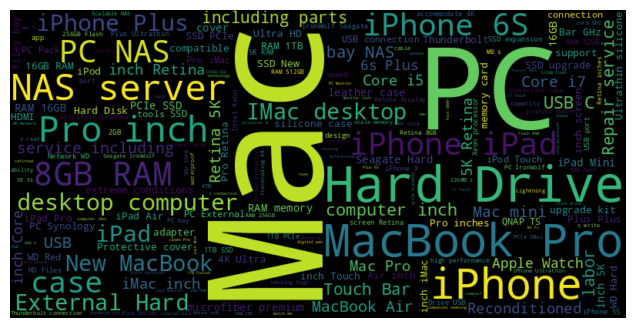

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Concatenate all text data into a single string
text = ' '.join(top_30_types['desc'])

#Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    colormap='viridis',
    contour_color='steelblue'
  ).generate(text)

#Display the word cloud using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

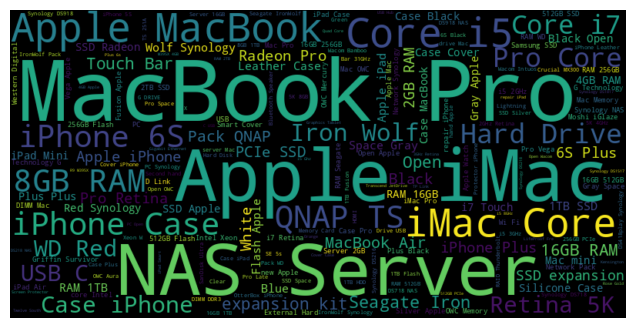

In [ ]:
#Concatenate all text data into a single string
text = ' '.join(top_30_types['name'])

#Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    colormap='viridis',
    contour_color='steelblue'
  ).generate(text)

#Display the word cloud using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

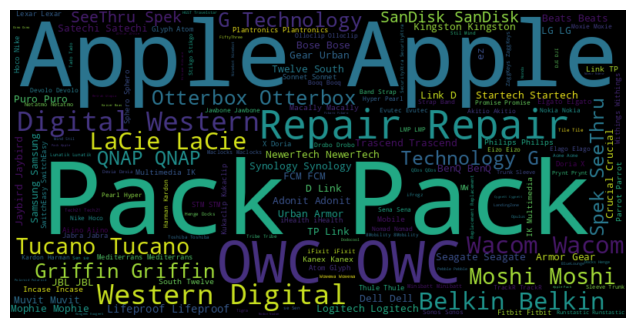

In [ ]:
#Concatenate all text data into a single string
text = ' '.join(top_30_types['long'])

#Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    colormap='viridis',
    contour_color='steelblue'
  ).generate(text)

#Display the word cloud using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()